In [3]:
import os
import json
import numpy as np
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict
from time import time
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image # Assuming the ResNet model implementation is in a package called resnet_model

# Assuming 'classes' contains the 7 classes of interest
import cv2
from pytorch_grad_cam import GradCAM


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [ ]:
!pip install pytorch_grad_cam

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import os
# import json
# import numpy as np
# import torch
# import torchvision
# from torch.utils.data import random_split
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# from sklearn.metrics import f1_score, accuracy_score
# from collections import defaultdict
# from time import time
# from tqdm import tqdm
# from datetime import datetime
# import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
class BatchNorm(nn.Module):
    def __init__(self,num_features,eps = 1e-5,momentum = 0.1,affine = True):
        super(BatchNorm,self).__init__()
        self.affine = affine
        self.curr_mean = 0
        self.curr_var = 0
        self.momentum = momentum
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
    def forward(self,x):
        if self.training:
            mean = x.mean(dim = (0,2,3),keepdim = True)
            var = x.var(dim = (0,2,3),unbiased = True,keepdim = True)
            with torch.no_grad():
                self.curr_mean = (1-self.momentum)*self.curr_mean + self.momentum*mean
                self.curr_var = (1-self.momentum)*self.curr_var + self.momentum*var
        else:
            mean = self.curr_mean
            var = self.curr_var
        x = (x-mean)/(torch.sqrt(var+self.eps))
        if self.affine:
            x = x*self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)
        return x

    

class InstanceNorm(nn.Module):
    def __init__(self,num_features,eps = 1e-5,momentum = 0.1,affine = True):
        super(InstanceNorm,self).__init__()
        self.affine = affine
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
    def forward(self,x):
        mean = x.mean(dim = (2,3),keepdim = True)
        var = x.var(dim = (2,3),keepdim = True)
        x = (x-mean)/torch.sqrt(var+self.eps)
        if(self.affine):
            x = x*self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)
        return x


    
class BatchInstanceNorm(nn.Module):
    def __init__(self,num_features,momentum = 0.1,eps = 1e-5,affine = True,rho = 0.5):
        super(BatchInstanceNorm,self).__init__()
        self.affine = affine
        self.curr_mean = 0
        self.curr_var = 0
        self.momentum = momentum
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
        self.rho = rho
        
    def forward(self,x):
        if self.training:
#             print(x.shape)
            batch_mean = x.mean(dim = (0,2,3),keepdim = True)
            batch_var = x.var(dim = (0,2,3),unbiased = True,keepdim = True)
            with torch.no_grad():
                self.curr_mean = (1-self.momentum)*self.curr_mean + self.momentum*batch_mean
                self.curr_var = (1-self.momentum)*self.curr_var + self.momentum*batch_var
        else:
            batch_mean = self.curr_mean
            batch_var = self.curr_var
        x_batch = (x-batch_mean)/torch.sqrt(batch_var+self.eps)
        instance_mean = x.mean(dim = (2,3),keepdim = True)
        instance_var = x.var(dim = (2,3),keepdim = True)
        x_instance = (x-instance_mean)/torch.sqrt(instance_var+self.eps)
        x = self.rho*x_batch + (1 - self.rho)*x_instance
        if self.affine:
            x = x*self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)
        return x

class LayerNorm(nn.Module):
    def __init__(self,num_features,eps = 1e-5,affine = True):
        super(LayerNorm,self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = torch.tensor(eps)
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
    def forward(self,x):
        mean = x.mean(dim = (1,2,3),keepdim = True)
        var = x.var(dim = (1,2,3),keepdim = True)
        x = (x-mean)/torch.sqrt(var+self.eps)
        if self.affine:
            x = x*self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)
        return x

class GroupNorm(nn.Module):
    def __init__(self,num_features,num_groups = 4,eps = 1e-5,affine = True):
        super(GroupNorm,self).__init__()
        self.eps = eps
        self.num_groups = num_groups
        self.affine = affine
        self.num_features = num_features
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
    def forward(self,x):
        N,C,H,W = x.shape
        x = x.view(N,self.num_groups,-1)
        mean = x.mean(dim = 2,keepdim = True)
        var = x.var(dim = 2,keepdim = True)
        x = (x-mean)/torch.sqrt(var+self.eps)
        x = x.view(N,C,H,W)
        if(self.affine):
            x = x*self.gamma.view(1,-1,1,1) + self.beta.view(1,-1,1,1)
        return x
        
class NoNorm(nn.Module):
    def __init__(self):
        super(NoNorm,self).__init__()
    def forward(self,x):
        return x
def normalization(dim,norm_type):
    if norm_type == 'default':
        return nn.BatchNorm2d(dim)
    elif norm_type == 'nn':
        return NoNorm()
    elif norm_type == 'bn':
        return BatchNorm(num_features = dim)
    elif norm_type == 'in':
        return InstanceNorm(num_features = dim)
    elif norm_type == 'bin':
        return BatchInstanceNorm(num_features = dim)
    elif norm_type == 'ln':
        return LayerNorm(num_features = dim)
    elif norm_type == 'gn':
        return GroupNorm(num_features = dim)
    
if torch.cuda.is_available():
    device = "cuda"
    print('using device: cuda')
else:
    device = "cpu"
    print('using device: cpu')
class Residual_Block(nn.Module):
    def __init__(self,in_channels,out_channels,norm_type = "default",stride = 1):
        super(Residual_Block,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.norm_type = norm_type
        self.stride = stride
        self.conv1 = nn.Conv2d(self.in_channels,self.out_channels,kernel_size = 3,stride = stride,padding = 1,bias = False)
        self.bn1 = normalization(out_channels,norm_type)
        self.conv2 = nn.Conv2d(self.out_channels,self.out_channels,kernel_size = 3,stride = 1,padding = 1,bias = False)
        self.bn2 = normalization(out_channels,norm_type)
        self.relu = nn.ReLU()
        self.downsample = nn.Sequential()
        if(stride != 1 or self.in_channels!=self.out_channels):
            self.downsample = nn.Sequential(nn.Conv2d(self.in_channels,self.out_channels,
                                                      kernel_size = 3,stride = stride,padding = 1,bias = False),normalization(self.out_channels,norm_type))
    def forward(self,x):
        residual = self.downsample(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        o = self.relu(x)
        return o
        
class ResNet(nn.Module):
    def __init__(self,n,r,norm_type = "default"):
        super(ResNet,self).__init__()
        self.n = n
        self.r = r
        self.norm_type = norm_type
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3,stride = 1,padding = 1,bias = False)
        self.bn1 = normalization(16,norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.create_layer(16,self.n)
        self.layer2 = self.create_layer(32,self.n,stride = 2)
        self.layer3 = self.create_layer(64,self.n,stride = 2)
        self.avg_pool = nn.AvgPool2d(kernel_size = 64)
        self.fc = nn.Linear(64,self.r)
            
    def create_layer(self,channels,n,stride = 1):
        layers = []
        layers.append(Residual_Block(self.in_channels,channels,self.norm_type,stride))
        self.in_channels = channels
        for i in range(1,n):
            layers.append(Residual_Block(self.in_channels,channels,self.norm_type))
        return nn.Sequential(*layers)
            
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
class Bird_dataset():
    def __init__(self,path,transform = None):
        self.data = datasets.ImageFolder(root = path,transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
def get_data(path):
    path_train = path +'/train'
    path_val = path + '/val'
    path_test = path + '/test'
    train_data = Bird_dataset(path_train,transform)
    val_data = Bird_dataset(path_val,transform)
    test_data = Bird_dataset(path_test,transform)
    return train_data,val_data,test_data
def get_loader(train_data,val_data,test_data,batch_size = 32,num_workers = 4):
    train_loader = DataLoader(train_data,batch_size = batch_size,shuffle = True,num_workers = num_workers)
    val_loader = DataLoader(val_data,batch_size = batch_size,shuffle = False,num_workers = num_workers)
    test_loader = DataLoader(test_data,batch_size = batch_size,shuffle = False,num_workers = num_workers)
    return train_loader,val_loader,test_loader
train_data,val_data,test_data = get_data('/kaggle/input/ind-bird-data/Birds_25')
train_loader,val_loader,test_loader = get_loader(train_data,val_data,test_data,batch_size = 32,num_workers = 4)
 
# os.makedirs('/kaggle/working/val')
# os.makedirs('/kaggle/working/test')
# os.makedirs('/kaggle/working/train')
# os.makedirs('/kaggle/working/model')
# os.makedirs('/kaggle/working/result')
def train():
    norms = ['default','bn','in','bin','gn','nn','ln']
    model = ResNet(n = 2, r = 25,norm_type = norms[4])
#     print(model)
    model = nn.DataParallel(model)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr = 0.1,weight_decay = 1e-4,momentum = 0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,50,verbose = False)
    
    loss_dict = defaultdict(list)
    accuracy_dict = defaultdict(list)
    f1_dict_micro = defaultdict(list)
    f1_dict_macro = defaultdict(list)
    
    best_accuracy = -1
    best_accuracy_epoch = -1
    print("----------------------Training Starts---------------------------------")
    for epoch in range(50):
        print("\n--------------- epoch: ",epoch)
        
        loss = []
        predictions = []
        actuals = []
        
        model.train()
        for idx,batch in enumerate(train_loader):
            images,labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            outs = model(images)
            
            error = criterion(outs,labels)
            loss.append(error.item())
            error.backward()
            if (idx+1)%2 == 0:
                optimizer.zero_grad()
                optimizer.step()
            actuals.extend(labels.squeeze().tolist())
            predictions.extend(torch.argmax(outs,dim = 1).squeeze().tolist())
            
        loss_dict["train"].append(np.mean(loss))
        accuracy_dict["train"].append(round(accuracy_score(actuals,predictions)*100,2))
        f1_dict_micro["train"].append(round(f1_score(actuals,predictions,average = 'micro'),4))
        f1_dict_macro["train"].append(round(f1_score(actuals,predictions,average = 'macro'),4))
                                      
        scheduler.step()
        
        print("-----------------------Validation------------------------")
        model.eval()
        
        loss_val = []
        predictions = []
        actuals = []
                                      
        for idx,batch in enumerate(val_loader):
            
            images,labels = batch
            images = images.to(device)
            labels = labels.to(device)
                                      
            actuals.extend(labels.squeeze().tolist())
            outs = model(images)
            predictions.extend(torch.argmax(outs,dim = 1).squeeze().tolist())
                                      
            error = criterion(outs,labels)
            loss_val.append(error.item())
            
        f1_dict_micro["val"].append(round(f1_score(actuals,predictions,average = 'micro'),4))
        f1_dict_macro["val"].append(round(f1_score(actuals,predictions,average = 'macro'),4))
        loss_dict["val"].append(np.mean(loss_val))
        accuracy_dict["val"].append(round(accuracy_score(actuals,predictions)*100,2))
        val_accuracy = accuracy_dict["val"][-1]
        
        print("Epoch: {},Train Loss: {},Train Accuracy: {}%,Train_f1_micro: {},Train_f1_macro: {},Validation Loss: {}, Validation Accuracy: {}%,Validation_f1_micro: {}, Validation_f1_macro: {} ".format(epoch,loss_dict["train"][-1],accuracy_dict["train"][-1],f1_dict_micro["train"][-1],f1_dict_macro["train"][-1],loss_dict["val"][-1],accuracy_dict["val"][-1],f1_dict_micro["val"][-1],f1_dict_macro["val"][-1]))
                                      
        curr_state = {"accuracy":val_accuracy,"epoch":epoch,"best_accuracy":best_accuracy,"best_accuracy_epoch":best_accuracy_epoch}
        
        print(f"epoch: {epoch}, Saving model checkpoint")
              
        torch.save(model,os.path.join('/kaggle/working/model','latest_checkpoint_gn_128.pth'))
        
        with open(os.path.join('/kaggle/working/train','training_curr_state_gn_128.json'),'w') as outfile:
              json.dump(curr_state,outfile)
        
        if val_accuracy > best_accuracy:
            
            print(f"best accuracy updated = {val_accuracy} against {best_accuracy}")
            best_accuracy = val_accuracy
            best_accuracy_epoch = epoch
            state = {"accuracy":val_accuracy,"epoch":epoch,"best_accuracy":best_accuracy,"best_accuracy_epoch":best_accuracy_epoch}
            torch.save(model,os.path.join('/kaggle/working/model','best_model_checkpoint_gn_128.pth'))
            with open(os.path.join('/kaggle/working/train','training_best_state_gn_128.json'),'w') as outfile:
                json.dump(state,outfile)
        
        with open(os.path.join('/kaggle/working/result','loss_dict_gn_128.json'),"w") as outfile:
            json.dump(loss_dict,outfile)
        with open(os.path.join('/kaggle/working/result','accuracy_dict_gn_128.json'),"w") as outfile:
            json.dump(accuracy_dict,outfile)
        with open(os.path.join('/kaggle/working/result','f1_score_micro_dict_gn_128.json'),"w") as outfile:
            json.dump(f1_dict_micro,outfile)
        with open(os.path.join('/kaggle/working/result','f1_score_macro_dict_gn_128.json'),"w") as outfile:
            json.dump(f1_dict_macro,outfile)
    return
# train()
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()    
 

using device: cuda


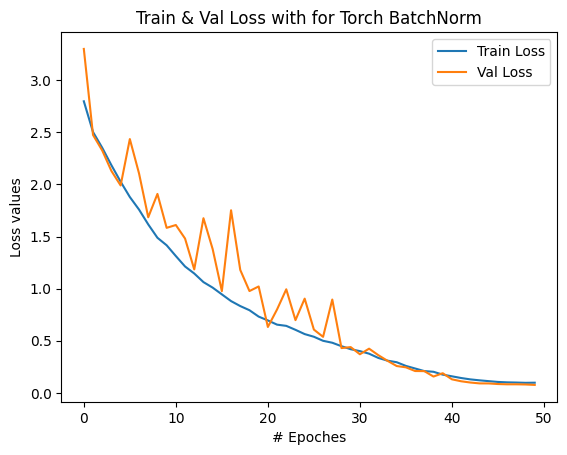

In [7]:
with open("/kaggle/input/bn-default/result/loss_dict_default_norm.json") as file:
    loss_dict = json.load(file)
plt.plot(list(range(len(loss_dict['train']))), loss_dict['train'], label="Train Loss")
plt.plot(list(range(len(loss_dict['val']))), loss_dict['val'], label="Val Loss")
# plt.axvline(x = np.argmin(loss_dict['val']), linestyle="dotted", label = f"Early Stopping (epoch={np.argmin(loss_dict['val'])})")
plt.title("Train & Val Loss with for Torch BatchNorm")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('loss_default.png')
plt.legend()

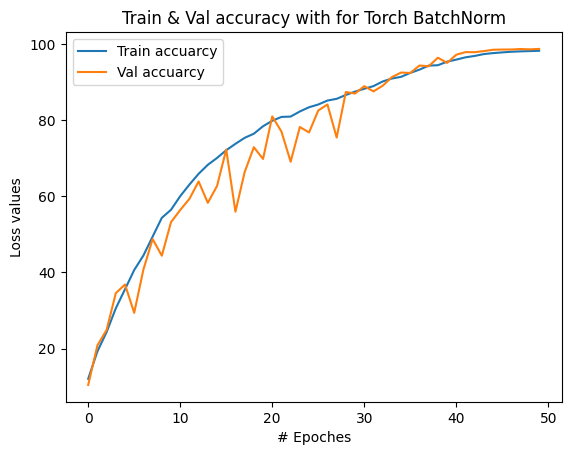

In [8]:
with open("/kaggle/input/bn-default/result/accuracy_dict_default_norm.json") as file:
    accuracy_dict = json.load(file)
plt.plot(list(range(len(accuracy_dict['train']))), accuracy_dict['train'], label="Train accuarcy")
plt.plot(list(range(len(accuracy_dict['val']))), accuracy_dict['val'], label="Val accuarcy")
plt.title("Train & Val accuracy with for Torch BatchNorm")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('accuracy_default.png')
plt.legend()

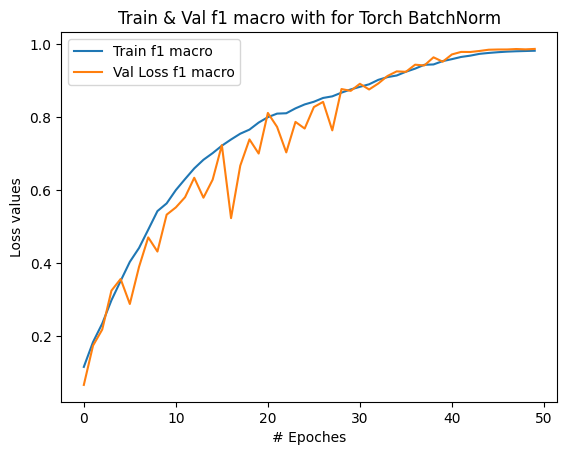

In [9]:
with open("/kaggle/input/bn-default/result/f1_score_macro_dict_default_norm.json") as file:
    f1_macro_dict = json.load(file)
plt.plot(list(range(len(f1_macro_dict['train']))), f1_macro_dict['train'], label="Train f1 macro ")
plt.plot(list(range(len(f1_macro_dict['val']))), f1_macro_dict['val'], label="Val Loss f1 macro")
plt.title("Train & Val f1 macro with for Torch BatchNorm")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('f1_macro_default.png')
plt.legend()

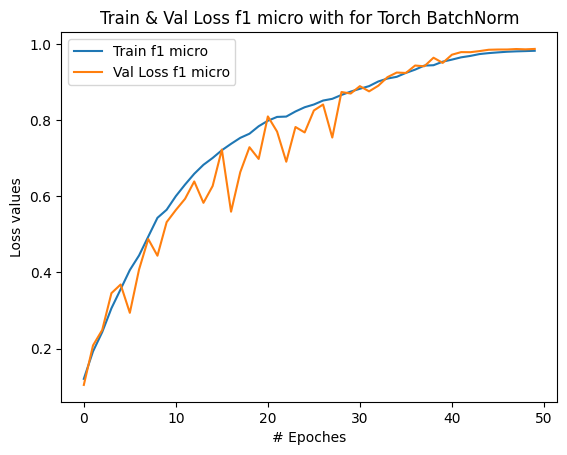

In [10]:
with open("/kaggle/input/bn-default/result/f1_score_micro_dict_default_norm.json") as file:
    f1_micro_dict = json.load(file)
plt.plot(list(range(len(f1_micro_dict['train']))), f1_micro_dict['train'], label="Train f1 micro ")
plt.plot(list(range(len(f1_micro_dict['val']))), f1_micro_dict['val'], label="Val Loss f1 micro")
plt.title("Train & Val Loss f1 micro with for Torch BatchNorm")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('f1_micro_default.png')
plt.legend()

In [15]:
# model = torch.load('/kaggle/input/bn-default/model/best_model_checkpoint_default_norm.pth')
# model_in = torch.load('/kaggle/input/norm-in/model/best_model_checkpoint_in.pth')
# model_nn = torch.load('/kaggle/input/norm-nn/model/best_model_checkpoint_nn.pth')
# model_ln = torch.load('/kaggle/input/norm-ln/model/best_model_checkpoint_ln.pth')
# model_gn = torch.load('/kaggle/input/norm-gn/model/best_model_checkpoint_gn.pth')
# model_bn = torch.load('/kaggle/input/norm-bn/model/best_model_checkpoint_bn.pth')
model_bin = torch.load('/kaggle/input/norm-binn/model/best_model_checkpoint_bin.pth')

In [12]:

accuracy_dict = defaultdict(list)
f1_dict_micro = defaultdict(list)
f1_dict_macro = defaultdict(list)
    

predictions = []
actuals = []
model_bin.eval()
for idx,batch in enumerate(train_loader):
    images,labels = batch
    images = images.to(device)
    labels = labels.to(device)

    outs = model_bin(images)

    actuals.extend(labels.squeeze().tolist())
    predictions.extend(torch.argmax(outs,dim = 1).squeeze().tolist())

accuracy_dict["train"].append(round(accuracy_score(actuals,predictions)*100,2))
f1_dict_micro["train"].append(round(f1_score(actuals,predictions,average = 'micro'),4))
f1_dict_macro["train"].append(round(f1_score(actuals,predictions,average = 'macro'),4))

print("-----------------------Validation------------------------")

predictions = []
actuals = []

for idx,batch in enumerate(val_loader):

    images,labels = batch
    images = images.to(device)
    labels = labels.to(device)

    actuals.extend(labels.squeeze().tolist())
    outs = model_bin(images)
    predictions.extend(torch.argmax(outs,dim = 1).squeeze().tolist())

    
f1_dict_micro["val"].append(round(f1_score(actuals,predictions,average = 'micro'),4))
f1_dict_macro["val"].append(round(f1_score(actuals,predictions,average = 'macro'),4))
accuracy_dict["val"].append(round(accuracy_score(actuals,predictions)*100,2))

predictions = []
actuals = []

for idx,batch in enumerate(test_loader):

    images,labels = batch
    images = images.to(device)
    labels = labels.to(device)

    actuals.extend(labels.squeeze().tolist())
    outs = model_bin(images)
    predictions.extend(torch.argmax(outs,dim = 1).squeeze().tolist())


f1_dict_micro["test"].append(round(f1_score(actuals,predictions,average = 'micro'),4))
f1_dict_macro["test"].append(round(f1_score(actuals,predictions,average = 'macro'),4))
accuracy_dict["test"].append(round(accuracy_score(actuals,predictions)*100,2))

print("Train Accuracy: {}%,Train_f1_micro: {},Train_f1_macro: {}, Validation Accuracy: {}%,Validation_f1_micro: {}, Validation_f1_macro: {}, Test_accuracy: {}%, Test_f1_micro: {}, Test_f1_macro: {}".format(accuracy_dict["train"][-1],f1_dict_micro["train"][-1],f1_dict_macro["train"][-1],accuracy_dict["val"][-1],f1_dict_micro["val"][-1],f1_dict_macro["val"][-1],accuracy_dict["test"][-1],f1_dict_micro["test"][-1],f1_dict_macro["test"][-1]))

KeyboardInterrupt: 

In [ ]:
with open("/kaggle/input/norm-in/result/loss_dict_in.json") as file:
    loss_dict_in = json.load(file)
with open("/kaggle/input/norm-nn/result/loss_dict_nn.json") as file:
    loss_dict_nn = json.load(file)
with open("/kaggle/input/norm-ln/result/loss_dict_ln.json") as file:
    loss_dict_ln = json.load(file)
with open("/kaggle/input/norm-gn/result/loss_dict_gn.json") as file:
    loss_dict_gn = json.load(file)
with open("/kaggle/input/norm-bn/result/loss_dict_bn.json") as file:
    loss_dict_bn = json.load(file)
with open("/kaggle/input/norm-binn/result/loss_dict_bin.json") as file:
    loss_dict_bin = json.load(file)

plt.plot(list(range(len(loss_dict_in['train']))), loss_dict_in['train'], label="instance norm")
plt.plot(list(range(len(loss_dict_bin['train']))), loss_dict_bin['train'], label="batch instance norm")
plt.plot(list(range(len(loss_dict_bn['train']))), loss_dict_bn['train'], label="batch norm")
plt.plot(list(range(len(loss_dict_gn['train']))), loss_dict_gn['train'], label="group norm")
plt.plot(list(range(len(loss_dict_ln['train']))), loss_dict_ln['train'], label="layer norm")
plt.plot(list(range(len(loss_dict_nn['train']))), loss_dict_nn['train'], label="no norm")
# plt.axvline(x = np.argmin(loss_dict['val']), linestyle="dotted", label = f"Early Stopping (epoch={np.argmin(loss_dict['val'])})")
plt.title("Train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('train_loss_all_norm.png')
plt.legend()

In [ ]:
plt.plot(list(range(len(loss_dict_in['val']))), loss_dict_in['val'], label="instance norm")
plt.plot(list(range(len(loss_dict_bin['val']))), loss_dict_bin['val'], label="batch instance norm")
plt.plot(list(range(len(loss_dict_bn['val']))), loss_dict_bn['val'], label="batch norm")
plt.plot(list(range(len(loss_dict_gn['val']))), loss_dict_gn['val'], label="group norm")
plt.plot(list(range(len(loss_dict_ln['val']))), loss_dict_ln['val'], label="layer norm")
plt.plot(list(range(len(loss_dict_nn['val']))), loss_dict_nn['val'], label="no norm")

plt.title("val loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('val_loss_all_norm.png')
plt.legend()

In [ ]:
plt.plot(list(range(len(loss_dict_bn['val']))), loss_dict_bn['val'], label="batch norm")
plt.plot(list(range(len(loss_dict['val']))), loss_dict['val'], label="torch batch norm")

plt.title("val loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('val_loss_torch_bn_and_bn _norm.png')
plt.legend()

In [ ]:
plt.plot(list(range(len(loss_dict_bn['train']))), loss_dict_bn['train'], label="batch norm")
plt.plot(list(range(len(loss_dict['train']))), loss_dict['train'], label="torch batch norm")

plt.title("train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('train_loss_torch_bn_and_bn _norm.png')
plt.legend()

In [ ]:
with open("/kaggle/input/torch-bn128/result/loss_dict_bn_128.json") as file:
    loss_dict_bn128 = json.load(file)
with open("/kaggle/input/torch-gn128/result/loss_dict_gn_128.json") as file:
    loss_dict_gn128 = json.load(file)
with open("/kaggle/input/norm-gn-8/result/loss_dict_gn_8.json") as file:
    loss_dict_gn8 = json.load(file)
with open("/kaggle/input/norm-bn-8/result/loss_dict_bn_8.json") as file:
    loss_dict_bn8 = json.load(file)

In [ ]:


plt.plot(list(range(len(loss_dict_bn128['train']))), loss_dict_bn128['train'], label="batch norm 128")
plt.plot(list(range(len(loss_dict_gn128['train']))), loss_dict_gn128['train'], label="group norm 128")

plt.title("train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('train_loss_bn128_and_gn128_norm.png')
plt.legend()

In [ ]:
# print(loss_dict_gn128['val'])
plt.plot(list(range(len(loss_dict_bn128['val']))), loss_dict_bn['val'], label="batch norm 128")
plt.plot(list(range(len(loss_dict_gn128['val']))), loss_dict_gn128['val'], label="group norm 128")

plt.title("train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('val_loss_bn128_and_gn128_norm.png')
plt.legend()

In [ ]:
plt.plot(list(range(len(loss_dict_bn8['val']))), loss_dict_bn8['val'], label="batch norm 8")
plt.plot(list(range(len(loss_dict_gn8['val']))), loss_dict_gn8['val'], label="group norm 8")

plt.title("train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('val_loss_bn8_and_gn8_norm.png')
plt.legend()

In [ ]:
plt.plot(list(range(len(loss_dict_bn128['train']))), loss_dict_bn8['train'], label="batch norm 8")
plt.plot(list(range(len(loss_dict_gn128['train']))), loss_dict_gn8['train'], label="group norm 8")

plt.title("train loss v/s epoch")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.savefig('train_loss_bn8_and_gn8_norm.png')
plt.legend()

In [ ]:
with open("/kaggle/input/torch-bn128/result/accuracy_dict_bn_128.json") as file:
    accuracy_dict_bn128 = json.load(file)
with open("/kaggle/input/torch-gn128/result/accuracy_dict_gn_128.json") as file:
    accuracy_dict_gn128 = json.load(file)
with open("/kaggle/input/norm-gn-8/result/accuracy_dict_gn_8.json") as file:
    accuracy_dict_gn8 = json.load(file)
with open("/kaggle/input/norm-bn-8/result/accuracy_dict_bn_8.json") as file:
    accuracy_dict_bn8 = json.load(file)
print(accuracy_dict_bn8)

In [ ]:
# print(accuracy_dict_bn128)
# plt.plot(list(range(len(accurcay_dict_bn128['train']))), accuracy_dict_bn128['train'], label="batch norm 128")
# plt.plot(list(range(len(accuracy_dict_gn128['train']))), accuracy_dict_gn128['train'], label="group norm 128")

# plt.title("train accuracy v/s epoch")
# plt.xlabel("# Epoches")
# plt.ylabel("accuracy values")
# plt.savefig('train_accuracy_bn128_and_gn128_norm.png')
# plt.legend()

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image

# Define dataset loader

# Define GradCAM class
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.feature_maps = None
        self.gradients = None

    def forward(self, x):
        return self.model(x)

    def backward(self, gradients):
        self.model.zero_grad()
        gradients.backward(retain_graph=True)

    def get_gradients(self):
        return self.gradients

    def get_feature_maps(self):
        return self.feature_maps

    def compute_heatmap(self, image, target_class):
        if isinstance(image, torch.Tensor):
            input_tensor = image.unsqueeze(0)
        else:
            preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            input_tensor = preprocess(image).unsqueeze(0)

        input_tensor = input_tensor.to(device)  # Ensure input tensor is on the same device as the model

        input_tensor.requires_grad = True
        output = self.forward(input_tensor)
        target = torch.tensor([target_class]).to(device)
        loss = nn.CrossEntropyLoss()(output, target)

        self.backward(loss)
        gradients = self.get_gradients()

        feature_maps = self.get_feature_maps()
        weights = torch.mean(gradients, axis=(2, 3)).squeeze(0)
        heatmap = torch.zeros(feature_maps.shape[2], feature_maps.shape[3])
        for i, weight in enumerate(weights):
            heatmap += weight * feature_maps[0, i, :, :].detach().cpu()

        heatmap = torch.clamp(heatmap, min=0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()  # Assuming you have a GradCAM implementation package
  # Function to load the best performing model

# Define the classes
classes = ['Cattle Egret', 'Coppersmith Barbet', 'Indian Peacock', 'Red Wattled Lapwing',
           'Ruddy Shelduck', 'White Breasted Kingfisher', 'White Breasted Waterhen']

# Load the best performing model

# Initialize GradCAM
gradcam = GradCAM(model_bin)

# Iterate over each class
for class_name in classes:
    # Get class index
    class_index = classes.index(class_name)
    
    # Select 5 correctly classified images and 5 incorrectly classified images
    correctly_classified_images = []
    incorrectly_classified_images = []
    
    for idx,batch in enumerate(val_loader):
        images,labels = batch
        images = images.to(device)
        labels = labels.to(device)
        for i in range(16):
#         print(images)
    #     actuals.extend(labels.squeeze().tolist())
            if(labels[i]!=class_index):
                continue
            outs = model_bin(images[i].unsqueeze(0))
            pred = torch.argmax(outs,dim = 1).squeeze().tolist()
            if pred == class_index:
                correctly_classified_images.append(images[i])
            else:
                incorrectly_classified_images.append(images[i])

            if len(correctly_classified_images) == 5 and len(incorrectly_classified_images) == 5:
                break
                
    # Visualize correctly classified images
    for image in correctly_classified_images:
        # Compute gradient map
        gradient_map = gradcam.compute_heatmap(image, class_index)
        
        # Plot original image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()
        
        # Plot gradient map superimposed on the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.imshow(gradient_map, alpha=0.5, cmap='jet')
        plt.title('Gradient Map (Correctly Classified)')
        plt.axis('off')
        plt.show()
        
    # Visualize incorrectly classified images
    for image in incorrectly_classified_images:
        # Compute gradient map
        gradient_map = gradcam.compute_heatmap(image, class_index)
        
        # Plot original image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()
        
        # Plot gradient map superimposed on the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.imshow(gradient_map, alpha=0.5, cmap='jet')
        plt.title('Gradient Map (Incorrectly Classified)')
        plt.axis('off')
        plt.show()


TypeError: mean() received an invalid combination of arguments - got (NoneType, axis=tuple), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [33]:
for idx,batch in enumerate(val_loader):

    images,labels = batch
    images = images.to(device)
    labels = labels.to(device)
    print(images)
#     actuals.extend(labels.squeeze().tolist())
    outs = model_bin(images)
    pred = torch.argmax(outs,dim = 1).squeeze().tolist()
    print(pred)
    break
#     break

tensor([[[[-0.0588, -0.0588, -0.0588,  ..., -0.2235, -0.2000, -0.1922],
          [-0.0588, -0.0588, -0.0588,  ..., -0.2157, -0.2078, -0.2078],
          [-0.0588, -0.0588, -0.0588,  ..., -0.2157, -0.2157, -0.2235],
          ...,
          [ 0.2314,  0.2392,  0.2392,  ...,  0.3569,  0.3569,  0.3569],
          [ 0.2314,  0.2314,  0.2392,  ...,  0.3647,  0.3647,  0.3647],
          [ 0.2314,  0.2314,  0.2314,  ...,  0.3647,  0.3647,  0.3647]],

         [[ 0.0196,  0.0196,  0.0196,  ..., -0.1216, -0.1137, -0.1059],
          [ 0.0196,  0.0196,  0.0196,  ..., -0.1137, -0.1216, -0.1216],
          [ 0.0196,  0.0196,  0.0196,  ..., -0.1137, -0.1294, -0.1373],
          ...,
          [ 0.3569,  0.3647,  0.3647,  ...,  0.3725,  0.3725,  0.3725],
          [ 0.3647,  0.3647,  0.3647,  ...,  0.3804,  0.3804,  0.3804],
          [ 0.3647,  0.3647,  0.3569,  ...,  0.3804,  0.3804,  0.3804]],

         [[-0.3882, -0.3882, -0.3961,  ..., -0.4667, -0.4510, -0.4431],
          [-0.3882, -0.3882, -

In [27]:
# print(val_loader[0])

TypeError: 'DataLoader' object is not subscriptable